# Case Study 4: Computational Methods in Finance

# Charles Laferte - cl4249

In [3]:
import modulesForCalibration as mfc

import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import scipy.integrate as integrate
import pandas as pd

from scipy.optimize import fmin, fmin_bfgs, minimize
from scipy.stats import norm

import cmath
import math

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from tqdm import tqdm
from matplotlib import cm

## Simulate the market data with Heston Stochastic Volatility Model

Let's set the parameters we will consider for the Heston model:

In [4]:
S0 = 4100
r = 0.0485
mu = r
params = [0.02, 1.5, 0.05, 0.18, 0.5, 0.04]

Here, we chose to considerate the parameter we obtain working on the SP500 data during the last assignment.

In [36]:
N = 10*252 # 10 years * 252 trading day per year
T = 10
dt = T/N

In [37]:
def heston_simulated_prices(params, N, T, S0, r, mu, plot = False):
    kappa  = params[0]
    theta  = params[1]
    sigma  = params[2]
    rho    = params[3]
    v0     = params[4]
    
    # Define discretization parameters
    dt = T/N        # time increment
    M = 1           # number of simulations
    print('T:',T,'  N:', N, '  dt:', dt)
    #print(v0)

    # Generate random numbers
    Z1 = norm.rvs(size=(N, M))
    Z2 = rho*Z1 + np.sqrt(1-rho**2)*norm.rvs(size=(N, M))

    # Define arrays to store stock price and volatility paths
    S = np.zeros((N+1, M))
    v = np.zeros((N+1, M))

    # Set initial values
    S[0,:] = S0
    v[0,:] = v0 #theta
    #print(v0)
    
    # Calculate paths
    for i in range(N):
        v[i+1,:] = np.maximum(0, v[i,:] + kappa*(theta-v[i,:])*dt + sigma*np.sqrt(v[i,:])*np.sqrt(dt)*Z1[i,:])
        #print(v[i+1,:])
        S[i+1,:] = S[i,:] * np.exp((mu - 0.5*v[i,:])*dt + np.sqrt(v[i,:])*np.sqrt(dt)*Z2[i,:])
        #print(S[i+1,:])
    
    # Plot results
    if plot == True:
        plt.plot(S)
        plt.title('Simulated Heston Model Stock Price Path')
        plt.xlabel('Time Steps')
        plt.ylabel('Stock Price')
        plt.show()
    
        plt.plot(v)
        plt.title('Simulated Heston Model volatility Path')
        plt.xlabel('Time Steps')
        plt.ylabel('Volatility')
        plt.show()
        
    # Reshaping the outputs
    y = np.log(S)
    S = S.T
    S = S[0]
    v = v.T
    v = v[0]
    y = y.T
    y = y[0]
    
    return S, v, y
    

T: 10   N: 500   dt: 0.02


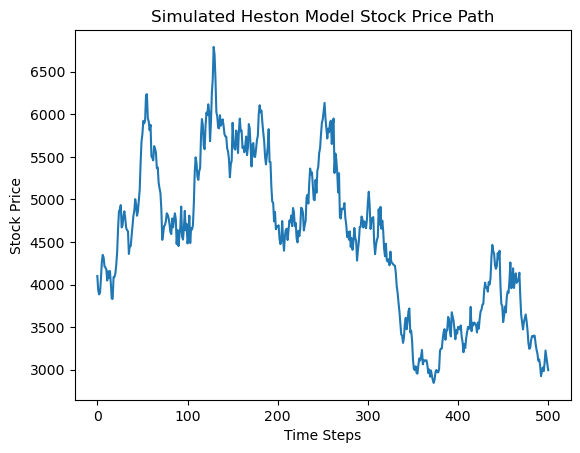

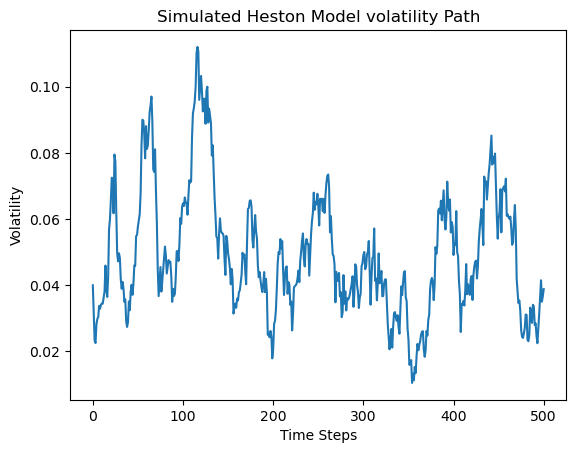

In [38]:
#prices, v_, y = heston_simulated_prices(params, N, T, S0, r, mu, plot = True)
S0 = 4100
r = 0.0485
mu = r
params = [mu, 1.5, 0.05, 0.18, 0.5, 0.04]
#.        mu, kappa, theta, lambda_, rho , v0
N = 500
T = 10

params_sim = np.zeros(5)
params_sim[0] = params[1]# kappa  
params_sim[1] = params[2]#theta  
params_sim[2] = params[3]#sigma  
params_sim[3] = params[4]#rho   
params_sim[4] = params[5]#v0  
#print(params_sim)
prices, v_, y = heston_simulated_prices(params_sim, N, T, S0, r, mu, plot = True)

## 1. Extended Kalman Filter

In [211]:
def Extended_Kalman_Filter(params):
    # Declare global variables
    global y_EKF, v_EKF
    
    # Extract parameters
    mu, kappa, theta, lbda, rho, v0 = params
    
    dt = T / N  # Calculate time step
    
    # Initialize matrices
    P = np.matrix([[0.01, 0], [0, 0.01]])
    I = np.identity(2)
    F = np.matrix([[1, -0.5*dt], [0, 1-kappa*dt]])
    U = np.matrix([[np.sqrt(v0*dt), 0], [0, lbda*np.sqrt(v0*dt)]])
    Q = np.matrix([[1, rho], [rho, 1]])
    H = np.matrix([1, 0])
    
    # Initialize state variables
    x_update = np.matrix([np.log(S0), v0]).T
    
    # Initialize arrays for storing results
    y_EKF = np.zeros(N)
    v_EKF = np.zeros(N)
    y_EKF[0] = np.log(S0)
    v_EKF[0] = v0
    
    loglk = 0  # Initialize objective function value
    for i in range(1, N):
        # Prediction step
        x_pred = np.matrix([0, 0], dtype=np.float64).T
        x_pred[0, 0] = x_update[0, 0] + (mu - 1/2*x_update[1, 0]) * dt
        x_pred[1, 0] = x_update[1, 0] + kappa * (theta - x_update[1, 0]) * dt
        
        P_1 = F * P * F.T + U * Q * U.T
        
        # Update step
        S = H * P_1 * H.T
        S = S[0, 0]
        
        e = y[i] - x_pred[0, 0]
        loglk += np.log(abs(S)) + e**2 / S
        
        K = P_1 * H.T / S
        x_update = x_pred + K * e
        
        # Apply full truncate scheme to avoid negative volatility values
        x_update[1, 0] = max(1e-5, x_update[1, 0]) 
        
        vk = x_update[1, 0]
        U = np.matrix([[np.sqrt(vk*dt), 0], [0, lbda*np.sqrt(vk*dt)]])
        P = (I - K * H) * P_1
        
        y_EKF[i] = x_update[0, 0]
        v_EKF[i] = x_update[1, 0]
        
    return loglk #/ N


In [199]:
# Define the objective function for optimization with noise
def objective(params):
    noise = np.random.normal(scale=0.01, size=len(params))  # Add random noise to the parameters
    params_with_noise = params + noise
    return Extended_Kalman_Filter(params_with_noise)

T: 10   N: 2520   dt: 0.003968253968253968


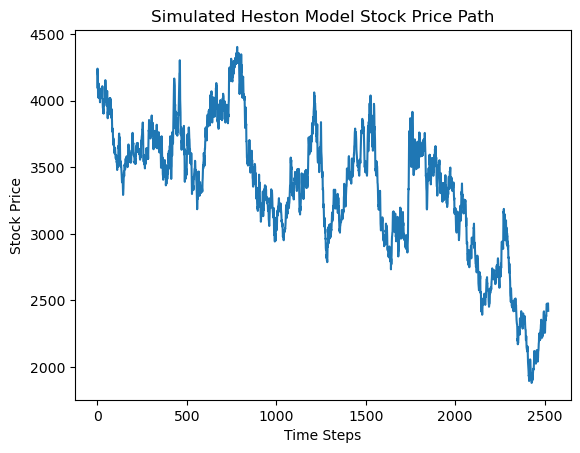

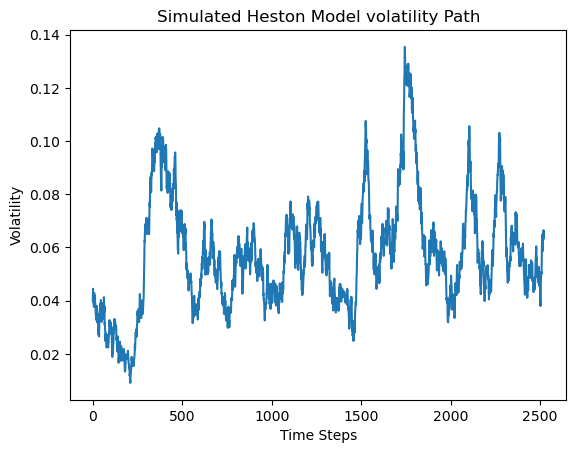

In [212]:
S0 = 4100
r = 0.0485
mu = r
params = [mu, 1.5, 0.05, 0.18, 0.5, 0.04]
#.        mu, kappa, theta, lambda_, rho , v0
N = 10*252 # 10 years * 252 trading day per year
T = 10

params_sim = np.zeros(5)
params_sim[0] = params[1]# kappa  
params_sim[1] = params[2]#theta  
params_sim[2] = params[3]#sigma  
params_sim[3] = params[4]#rho   
params_sim[4] = params[5]#v0  
#print(params_sim)
prices, v_, y = heston_simulated_prices(params_sim, N, T, S0, r, mu, plot = True)

dt = T/N
#print(dt)

Set the initial guess for the optimization : 

In [219]:
# true : [0.0485, 1.5, 0.05, 0.18, 0.5, 0.04]
params_0 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.05]
params_0 = [0.02, 1.5, 0.05, 0.18, 0.5, 0.1]
params_0 = [0.06, 1.3, 0.07, 0.3, 0.6, 0.04]

Use the Nelder-Mead algorithm to minimize the function

In [220]:
def opt_param_research():
    
    def callback(x):
        print("Current parameter vector:", x)
        print("Function value: ", Extended_Kalman_Filter(x))

    #constraint1 = {'type': 'ineq', 'fun': lambda x: x}#[0] - 1}
    #constraint2 = {'type': 'ineq', 'fun': lambda x: 2 - x[0]}
    #constraints = [constraint1]#, constraint2]
    bounds = [(0.000001, 30)]*6
    #bounds[1] = (0,2)
    bounds[4] = (-1,1)
    xopt = minimize(Extended_Kalman_Filter, params_0, callback=callback, method='Nelder-Mead',options={'maxiter': 100},bounds=bounds)
    #xopt_noise =minimize(objective, params_0, callback=callback, method='Nelder-Mead',options={'maxiter': 100},bounds=bounds)
     
    #result_2 = minimize(obj_function_ext_KF_m, params_0, bounds=bounds, callback=callback)# method='Nelder-Mead',
    #xopt, fopt, _, _, _ = fmin(ext_Kalman_filter, params_0, maxiter=100, callback=callback, disp=True, retall=False, full_output=True)

    #result = fmin(ext_Kalman_filter, params_0, callback=callback)
    print(80*'=')
    print('Optimal parameter set:')
    print(xopt)
    print(80*'=')
    
    return xopt

In [221]:
result_EKF = opt_param_research()

Current parameter vector: [0.0615  1.3325  0.07175 0.3075  0.54    0.041  ]
Function value:  -18574.696118761647
Current parameter vector: [0.0615  1.3325  0.07175 0.3075  0.54    0.041  ]
Function value:  -18574.696118761647
Current parameter vector: [0.0615  1.3325  0.07175 0.3075  0.54    0.041  ]
Function value:  -18574.696118761647
Current parameter vector: [0.0605     1.38666667 0.07466667 0.29666667 0.54666667 0.03766667]
Function value:  -18583.5072747409
Current parameter vector: [0.0605     1.38666667 0.07466667 0.29666667 0.54666667 0.03766667]
Function value:  -18583.5072747409
Current parameter vector: [0.0605     1.38666667 0.07466667 0.29666667 0.54666667 0.03766667]
Function value:  -18583.5072747409
Current parameter vector: [0.06133333 1.45527778 0.07369444 0.29111111 0.45777778 0.04088889]
Function value:  -18588.43820846982
Current parameter vector: [0.06133333 1.45527778 0.07369444 0.29111111 0.45777778 0.04088889]
Function value:  -18588.43820846982
Current parame

Function value:  -18608.32979332549
Current parameter vector: [0.07480402 1.72165924 0.06568394 0.29197681 0.34109707 0.02211956]
Function value:  -18608.32979332549
Current parameter vector: [0.07480402 1.72165924 0.06568394 0.29197681 0.34109707 0.02211956]
Function value:  -18608.32979332549
Current parameter vector: [0.07480402 1.72165924 0.06568394 0.29197681 0.34109707 0.02211956]
Function value:  -18608.32979332549
Current parameter vector: [0.07480402 1.72165924 0.06568394 0.29197681 0.34109707 0.02211956]
Function value:  -18608.32979332549
Current parameter vector: [0.07480402 1.72165924 0.06568394 0.29197681 0.34109707 0.02211956]
Function value:  -18608.32979332549
Current parameter vector: [0.07480402 1.72165924 0.06568394 0.29197681 0.34109707 0.02211956]
Function value:  -18608.32979332549
Current parameter vector: [0.07480402 1.72165924 0.06568394 0.29197681 0.34109707 0.02211956]
Function value:  -18608.32979332549
Current parameter vector: [0.07390152 1.72039658 0.065

In [222]:
print(result_EKF.x)

[0.04492611 1.6024584  0.06350905 0.1795651  0.4394318  0.02160711]


In [180]:
print(params)

[0.0485, 1.5, 0.05, 0.18, 0.5, 0.04]


## Plotting the results:

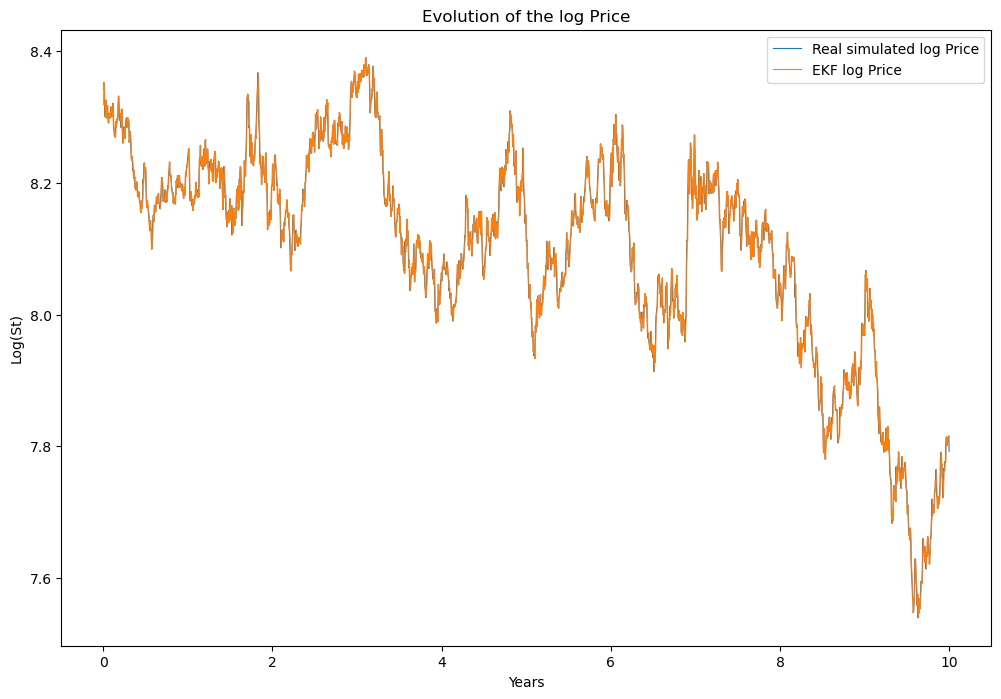

In [223]:
plt.figure(figsize=(12,8))
years = np.arange(y.shape[-1]) * dt
plt.plot(years[1:], y[1:], label = 'Real simulated log Price', linewidth=0.8)
plt.plot(years[1:], y_EKF, label = 'EKF log Price', linewidth=0.8)
plt.plot()
plt.title('Evolution of the log Price')
plt.ylabel('Log(St)')
plt.xlabel('Years')
plt.legend()
plt.show()

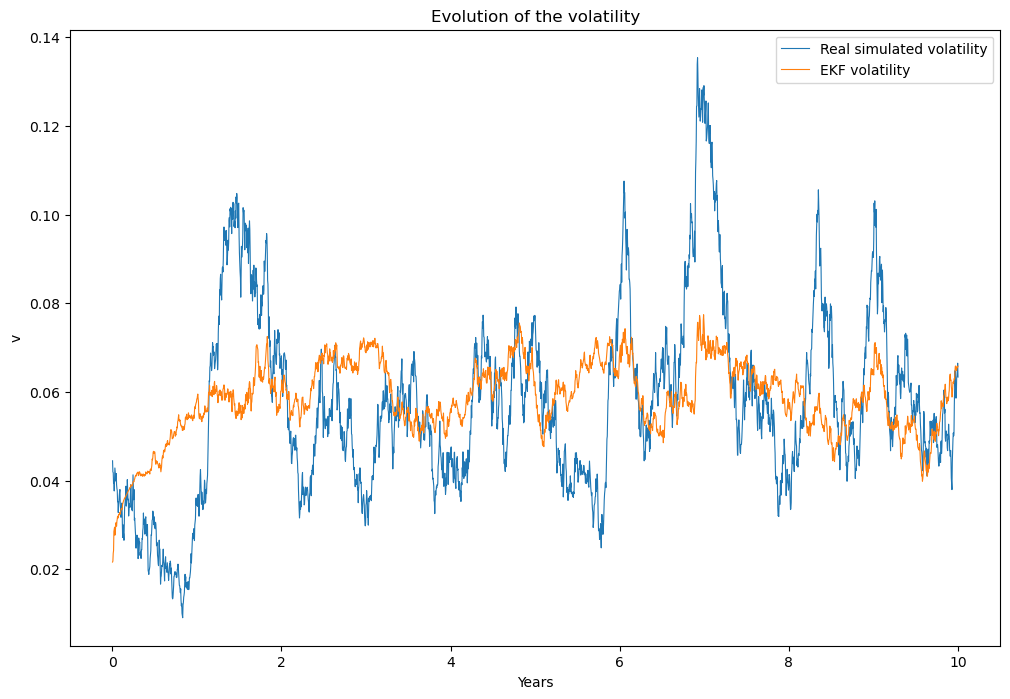

In [224]:
plt.figure(figsize=(12,8))
plt.plot(years[1:], v_[1:], label = 'Real simulated volatility', linewidth=0.8)
plt.plot(years[1:], v_EKF, label = 'EKF volatility', linewidth=0.8)
plt.plot()
plt.title('Evolution of the volatility')
plt.ylabel('v')
plt.xlabel('Years')
plt.legend()
plt.show()

## 2. Particle Filtering

### 2.1 Preparing the different functions

In [57]:
def proposal_distribution(N, v_prev, dy, params):
    mu, kappa, theta, lbda, rho = params
    # Calculate mean and standard deviation of the proposal distribution
    m = v_prev + kappa * (theta - v_prev) * dt + lbda * rho * (dy - (mu - 1/2 * v_prev) * dt)
    s = lbda * np.sqrt(v_prev * (1 - rho**2) * dt)
    # Sample N particles from the proposal distribution
    return norm.rvs(m, s, N)

def likelihood(y, x, v_prev, y_prev, params):
    mu, kappa, theta, lbda, rho = params
    # Calculate the mean and standard deviation of the measurement distribution
    m = y_prev + (mu - 1/2 * x) * dt
    s = np.sqrt(v_prev * dt)
    # Calculate the likelihood
    return norm.pdf(y, m, s)

def transition_proba(x, v_prev, params):
    mu, kappa, theta, lbda, rho = params
    # Calculate the mean and standard deviation of the transition distribution
    m = 1 / (1 + 1/2 * lbda * rho * dt) * (v_prev + kappa * (theta - v_prev) * dt + 1/2 * lbda * rho * v_prev * dt)
    s = 1 / (1 + 1/2 * lbda * rho * dt) * lbda * np.sqrt(v_prev * dt)
    # Calculate the transition probability
    return norm.pdf(x, m, s)

def propo(x, v_prev, dy, params):
    mu, kappa, theta, lbda, rho = params
    # Calculate the mean and standard deviation of the proposal distribution    
    m = v_prev + kappa*(theta-v_prev)*dt + lbda*rho*(dy - (mu-1/2*v_prev)*dt)
    s = lbda*np.sqrt(v_prev*(1-rho**2)*dt)
    return norm.pdf(x, m, s)

def parameter_states_init(N, bounds):
    current_params = np.zeros((len(bounds), N))
    b0, b1, b2, b3, b4 = bounds
    # Initialize each parameter state using uniform random values within the bounds
    current_params[0] = np.random.rand(N) * (b0[1] - b0[0]) + b0[0]
    current_params[1] = np.random.rand(N) * (b1[1] - b1[0]) + b1[0]
    current_params[2] = np.random.rand(N) * (b2[1] - b2[0]) + b2[0]
    current_params[3] = np.random.rand(N) * (b3[1] - b3[0]) + b3[0]
    current_params[4] = np.random.rand(N) * (b4[1] - b4[0]) + b4[0]

    return current_params

def resample_state(particles, w):
    N = len(particles)
    c_sum = np.cumsum(w)
    c_sum[-1] = 1.
    # Select new particles by randomly sampling from the cumulative sum
    idx = np.searchsorted(c_sum, np.random.rand(N))
    particles[:] = particles[idx]
    # Assign equal w to the new particles
    new_w = np.ones(len(w)) / len(w)
    
    return particles, new_w

def resample(v_pred, w, current_params):
        current_params[0], _ = resample_state(current_params[0], w)
        current_params[1], _ = resample_state(current_params[1], w)
        current_params[2], _ = resample_state(current_params[2], w)
        current_params[3], _ = resample_state(current_params[3], w)
        current_params[4], _ = resample_state(current_params[4], w)
        v_pred, w = resample_state(v_pred, w)
        return v_pred, w, current_params

def prediction_density(y, y_prev, x, mu):
    m = y_prev + (mu-1/2*x)*dt
    s = np.sqrt(x*dt)
    return norm.pdf(y, m, s)

def prediction_density_v(v, v_prev, dy, lbda,rho, theta, kappa):
    # Transition
    m = 1/(1+1/2*lbda*rho*dt) * (v_prev + kappa*(theta-v_prev)*dt + 1/2*lbda*rho*v_prev*dt)
    #print('m',m)
    s = (1/(1+1/2*lbda*rho*dt) * lbda * np.sqrt(v_prev*dt))
    return norm.pdf(v, m, s)

def inv_froeb(w):
        return 1. / np.sum(np.square(w))

In [58]:
def predict(v_pred, particles, y_prev, mu):
    # Generate predicted observations based on the predicted states
    y_hat = y_prev + (mu - 1 / 2 * v_pred) * dt + np.sqrt(particles * dt) * norm.rvs()
    # Calculate the prediction density for each predicted observation
    prediction_densities = [prediction_density(y_hat[k], y_prev, v_pred, mu) for k in range(len(y_hat))]
    # Calculate the average prediction density for each predicted observation
    pdf_y_hat = np.array([np.mean(density) for density in prediction_densities])
    # Normalize the prediction densities
    pdf_y_hat = pdf_y_hat / np.sum(pdf_y_hat)
    # Calculate the weighted sum of the predicted observations
    return np.sum(pdf_y_hat * y_hat)

def predict_v(v_pred, particles, v_prev, mu, lbda,rho, theta, kappa, w, params, dy):
    v_hat = v_prev + (theta-1/2*particles)*dt + lbda*rho*(((mu-1/2*particles)*dt)-(mu-1/2*particles)*dt) + lbda*np.sqrt((1-rho**2)*particles*dt)*norm.rvs() + lbda*rho*np.sqrt(particles*dt)*norm.rvs()
    pdf_v_hat = np.array([np.mean(prediction_density_v(v_hat[k], particles[k], dy,lbda,rho, theta,kappa)) for k in range(len(v_hat))])
    pdf_v_hat = pdf_v_hat/sum(pdf_v_hat)
    return np.sum(pdf_v_hat * v_hat)


In [166]:
def particle_filtering(params, N):
    global y_PF, v_PF, v_PF_bis
    
    # Unpack the model parameters
    mu, kappa, theta, lbda, rho, v0 = params
    
    print(params[:-1])
    
    # Initialize the current parameter states
    current_params = parameter_states_init(N, params[:-1])
    
    # Initialize the arrays to store the estimated states
    y_PF = np.zeros(N)
    v_PF = np.zeros(N)
    v_PF_bis = np.zeros(N)
    
    y_PF[0] = y[0]
    v_PF[0] = v0
    v_PF_bis[0] = v0
    
    # Initialize the weights
    w = np.array([1 / N] * N)
    
    # Initialize the particles
    particles = norm.rvs(v0, 0.02, N)
    particles = np.maximum(1e-4, particles)
    
    # Initialize the array to store the parameter steps
    params_steps = np.zeros((len(params) - 1, len(y)))
    params_steps.transpose()[0] = np.mean(current_params, axis=1)
    print(N)
    
    for i in range(1, N):
        dy = y[i] - y[i - 1]
        
        # Particle prediction step
        v_pred = proposal_distribution(N, particles, dy, current_params)
        v_pred = np.maximum(1e-3, v_pred)
        
        # Likelihood calculation
        Li = likelihood(y[i], v_pred, particles, y[i - 1], current_params)
        I = propo(v_pred, particles, dy, current_params)
        T = transition_proba(v_pred, particles, current_params)
        
        # Update the weights
        w = w * (Li * T / I)
        w = w / np.sum(w)
        
        # Resampling step
        if inv_froeb(w) < 0.75 * N:
            print('Resampling')
            v_pred, w, current_params = resample(v_pred, w, current_params)
        
        # State estimation step
        y_hat = predict(v_pred, particles, y[i - 1], np.mean(current_params[0]))
        y_PF[i] = y_hat
        v_PF_bis[i] = predict_v(v_pred, particles, v_PF[i - 1], np.mean(current_params[0]),
                                np.mean(current_params[3]), np.mean(current_params[4]),
                                np.mean(current_params[2]), np.mean(current_params[1]), w, current_params, dy)
        v_PF[i] = np.sum(v_pred * w)
        particles = v_pred
        params_steps.transpose()[i] = np.sum(np.multiply(current_params, w[np.newaxis, :]), axis=1)
        
        print("Iteration {} completed".format(i))
    last_param = np.sum(np.multiply(current_params, w[np.newaxis, :]), axis=1)
    return (v_PF, v_PF_bis, params_steps, y_PF, last_param)

### 2.2 Running the algorithm

T: 10   N: 500   dt: 0.02


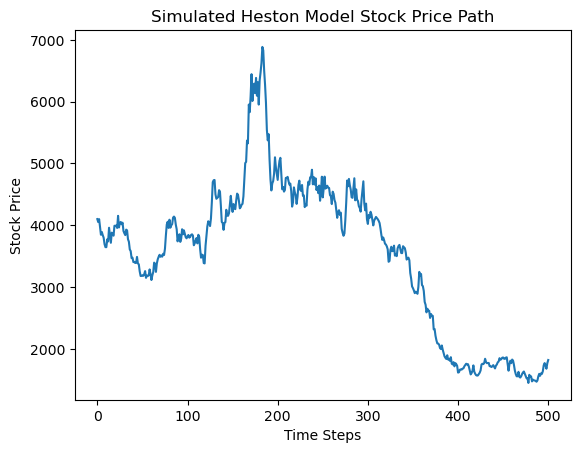

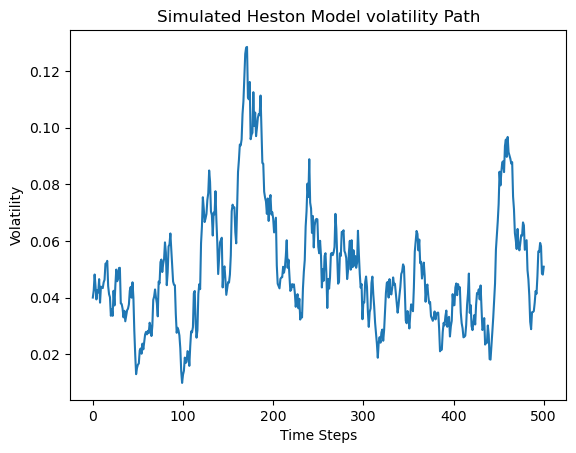

In [232]:
S0 = 4100
r = 0.0485
mu = r
params = [mu, 1.5, 0.05, 0.18, 0.5, 0.04]
#.        mu, kappa, theta, lbda, rho , v0
N = 500
T = 10

params_sim = np.zeros(5)
params_sim[0] = params[1]# kappa  
params_sim[1] = params[2]#theta  
params_sim[2] = params[3]#sigma  
params_sim[3] = params[4]#rho   
params_sim[4] = params[5]#v0  
#print(params_sim)
prices, v_, y = heston_simulated_prices(params_sim, N, T, S0, r, mu, plot = True)

dt = T/N
#print(dt)

In [233]:
print(params)

[0.0485, 1.5, 0.05, 0.18, 0.5, 0.04]


In [234]:
mu = (0.01, 0.05)
kappa = (0.5, 3)
theta = (0.02, 0.2)
lambda_ = (0.01, 0.91)
rho = (-0.5, 1)
v_0 = params[-1]

params_0 = np.array([[mu, kappa, theta, lambda_, rho, v_0]])
params_0 =[mu, kappa, theta, lambda_, rho, v_0]

In [242]:
v_PF_opt, v_bis, param_steps, y_PF_opt, last_param = particle_filtering(params_0, N)

[(0.01, 0.05), (0.5, 3), (0.02, 0.2), (0.01, 0.91), (-0.5, 1)]
500
Resampling
Iteration 1 completed
Resampling
Iteration 2 completed
Resampling
Iteration 3 completed
Iteration 4 completed
Resampling
Iteration 5 completed
Resampling
Iteration 6 completed
Resampling
Iteration 7 completed
Resampling
Iteration 8 completed
Iteration 9 completed
Resampling
Iteration 10 completed
Resampling
Iteration 11 completed
Resampling
Iteration 12 completed
Resampling
Iteration 13 completed
Resampling
Iteration 14 completed
Resampling
Iteration 15 completed
Resampling
Iteration 16 completed
Resampling
Iteration 17 completed
Resampling
Iteration 18 completed
Resampling
Iteration 19 completed
Resampling
Iteration 20 completed
Resampling
Iteration 21 completed
Resampling
Iteration 22 completed
Resampling
Iteration 23 completed
Resampling
Iteration 24 completed
Resampling
Iteration 25 completed
Resampling
Iteration 26 completed
Resampling
Iteration 27 completed
Resampling
Iteration 28 completed
Resampling
I

Iteration 237 completed
Resampling
Iteration 238 completed
Resampling
Iteration 239 completed
Resampling
Iteration 240 completed
Resampling
Iteration 241 completed
Resampling
Iteration 242 completed
Resampling
Iteration 243 completed
Resampling
Iteration 244 completed
Resampling
Iteration 245 completed
Resampling
Iteration 246 completed
Resampling
Iteration 247 completed
Resampling
Iteration 248 completed
Resampling
Iteration 249 completed
Resampling
Iteration 250 completed
Resampling
Iteration 251 completed
Resampling
Iteration 252 completed
Resampling
Iteration 253 completed
Resampling
Iteration 254 completed
Resampling
Iteration 255 completed
Resampling
Iteration 256 completed
Resampling
Iteration 257 completed
Resampling
Iteration 258 completed
Resampling
Iteration 259 completed
Resampling
Iteration 260 completed
Resampling
Iteration 261 completed
Resampling
Iteration 262 completed
Resampling
Iteration 263 completed
Resampling
Iteration 264 completed
Resampling
Iteration 265 comple

Resampling
Iteration 474 completed
Resampling
Iteration 475 completed
Resampling
Iteration 476 completed
Resampling
Iteration 477 completed
Resampling
Iteration 478 completed
Resampling
Iteration 479 completed
Resampling
Iteration 480 completed
Resampling
Iteration 481 completed
Resampling
Iteration 482 completed
Resampling
Iteration 483 completed
Resampling
Iteration 484 completed
Resampling
Iteration 485 completed
Resampling
Iteration 486 completed
Resampling
Iteration 487 completed
Resampling
Iteration 488 completed
Resampling
Iteration 489 completed
Resampling
Iteration 490 completed
Resampling
Iteration 491 completed
Resampling
Iteration 492 completed
Resampling
Iteration 493 completed
Resampling
Iteration 494 completed
Resampling
Iteration 495 completed
Resampling
Iteration 496 completed
Resampling
Iteration 497 completed
Resampling
Iteration 498 completed
Resampling
Iteration 499 completed


In [243]:
last_param

array([0.02730858, 1.62033214, 0.06120653, 0.25795131, 0.93447779])

### 2.3 Plotting the results:

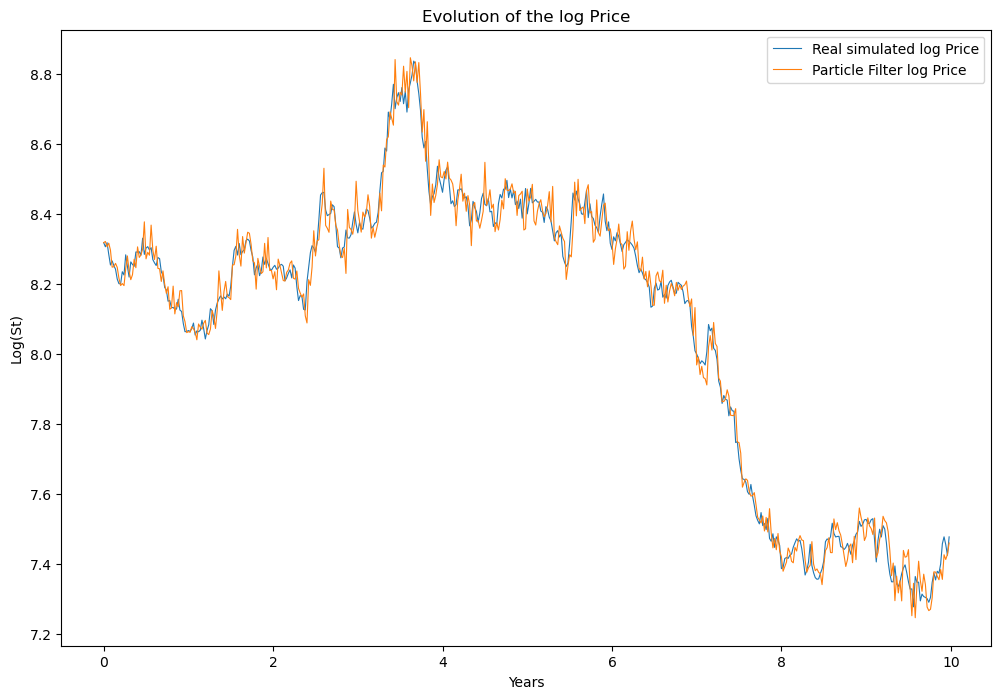

In [244]:
plt.figure(figsize=(12,8))
years = np.arange(obs.shape[-1]) * (T/N)
plt.plot(years, y[:-1], label = 'Real simulated log Price', linewidth=0.8)
plt.plot(years, y_PF_opt, label = 'Particle Filter log Price', linewidth=0.8)
plt.plot()
plt.title('Evolution of the log Price')
plt.ylabel('Log(St)')
plt.xlabel('Years')
plt.legend()
plt.show()

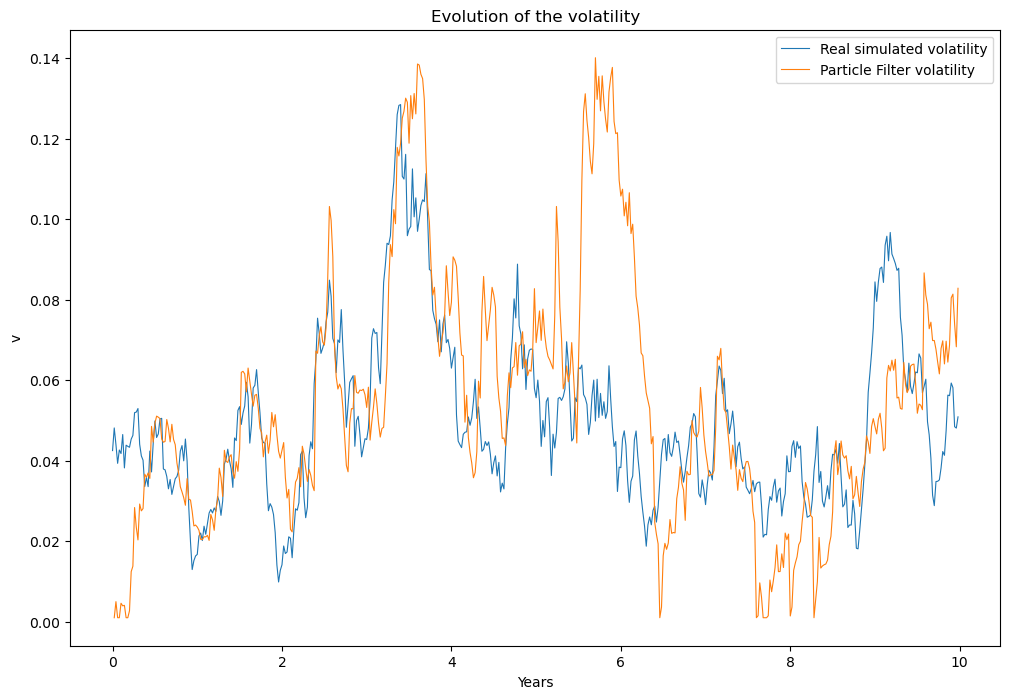

In [245]:
plt.figure(figsize=(12,8))
years = np.arange(v.shape[-1]) * (T/N)
plt.plot(years, v_[1:], label = 'Real simulated volatility', linewidth=0.8)
plt.plot(years[1:], v_PF_opt[1:], label = 'Particle Filter volatility', linewidth=0.8)
#plt.plot(years[1:], v_PF_bis[1:], label = 'Particle Filter volatility', linewidth=0.8)
plt.plot()
plt.title('Evolution of the volatility')
plt.ylabel('v')
plt.xlabel('Years')
plt.legend()
plt.show()

## Result

In [246]:
p_PF = np.append(last_param,0.04)
p_EKF = result_EKF.x

In [247]:
params_result = pd.DataFrame({})
params_result['From'] = ['Simulation (true values)','Extended Kalman Filter','Particle filter']
params_name = ['mu', 'kappa', 'theta', 'lambda_', 'rho', 'v_0']

for i in range(len(params)):
    params_result[params_name[i]] = [params[i],p_EKF[i], p_PF[i]]
params_result

,From,mu,kappa,theta,lambda_,rho,v_0
0,Simulation (true values),0.048500,1.500000,0.050000,0.180000,0.500000,0.040000
1,Extended Kalman Filter,0.044926,1.602458,0.063509,0.179565,0.439432,0.021607
2,Particle filter,0.027309,1.620332,0.061207,0.257951,0.934478,0.040000


We can see that both model get close to real parameters but struggle a bit. For instance the mu estimate of the particle filtering is quite far from the real one. It is worth noting that the two models worked on different data as the two algorithms running on same data would have lead to long computation times. We did not get the parameters back very precisely.

Looking at the graphs, we observe that the two models are able to stick to the price path but are quite noisy around the true volatility paths simulated.

Therefore, in the context of parameter estimation in the Heston stochastic volatility model, both EKF and PF can be used. However, the choice could depend on the specific characteristics of the model, the available data, and the desired accuracy of the estimation. Looking back at the way the models should perform, if the model is relatively linear and Gaussian, and the noise is well-behaved, the EKF may provide accurate estimates. On the other hand, if the model is nonlinear or the noise is non-Gaussian, the PF may be more appropriate to capture the complexity of the distribution and provide robust estimates.